## Imports & Path

In [15]:
import os, sys
sys.path.append(os.path.abspath(".."))

import pandas as pd

from src.data_loader import MarketDataConfig, fetch_prices, compute_returns
from src.portfolio import Portfolio, portfolio_returns
from src.var_models import historical_var, parametric_var_normal, parametric_var_ewma_normal
from src.backtest import var_exceptions, exception_summary, exception_table, kupiec_test_uc
from src.plots import plot_var_overlay
from src.scaling import scale_to_dollars


## Config & Data

In [16]:
cfg = MarketDataConfig(
    tickers=["SPY", "TLT", "GLD", "UUP"],
    start="2015-01-01",
    use_log_returns=True
)

prices = fetch_prices(cfg)
rets = compute_returns(prices, use_log=cfg.use_log_returns)

prices.tail(), rets.tail()


(Ticker             GLD         SPY        TLT     UUP
 Date                                                 
 2026-02-12  451.390015  681.270020  89.230003  26.820
 2026-02-13  462.619995  681.750000  89.720001  26.820
 2026-02-17  448.200012  682.849976  89.870003  26.910
 2026-02-18  458.279999  686.289978  89.529999  27.080
 2026-02-19  458.982391  686.289978  89.470100  27.125,
 Ticker           GLD       SPY       TLT       UUP
 Date                                              
 2026-02-12 -0.035346 -0.015569  0.013199 -0.000373
 2026-02-13  0.024574  0.000704  0.005476  0.000000
 2026-02-17 -0.031666  0.001612  0.001670  0.003350
 2026-02-18  0.022241  0.005025 -0.003790  0.006297
 2026-02-19  0.001531  0.000000 -0.000669  0.001660)

## Portfolio

In [17]:
port = Portfolio(weights={"SPY": 0.4, "TLT": 0.3, "GLD": 0.2, "UUP": 0.1})
pret = portfolio_returns(rets, port)
NOTIONAL = 10_000_000  # $10mm demo notional 
pnl = scale_to_dollars(pret, NOTIONAL) # use helper to scale pre-trade into dollars  

pret.describe()


count    2798.000000
mean        0.000303
std         0.005437
min        -0.045451
25%        -0.002395
50%         0.000619
75%         0.003173
max         0.049112
Name: portfolio_return, dtype: float64

## VaR Models

In [18]:
WINDOW = 252

# Historical VaR
var95_hist = historical_var(pret, window=WINDOW, alpha=0.05)
var95_hist_dollars = scale_to_dollars(var95_hist, NOTIONAL)
var99_hist = historical_var(pret, window=WINDOW, alpha=0.01)
var99_hist_dollars = scale_to_dollars(var99_hist, NOTIONAL)

# Parametric VaR
var95_param = parametric_var_normal(pret, window=WINDOW, alpha=0.05, use_mean=True)
var95_param_dollars = scale_to_dollars(var95_param, NOTIONAL)
var99_param = parametric_var_normal(pret, window=WINDOW, alpha=0.01, use_mean=True)
var99_param_dollars = scale_to_dollars(var99_param, NOTIONAL)

pd.concat([pret*100, var95_hist_dollars, var95_param_dollars, var99_hist_dollars, var99_param_dollars], axis=1).dropna().head()

# EWMA VaR (return space)
var95_ewma = parametric_var_ewma_normal(pret, alpha=0.05, lam=0.94, use_mean=False, burn_in=30)
var99_ewma = parametric_var_ewma_normal(pret, alpha=0.01, lam=0.94, use_mean=False, burn_in=30)

# Scale to dollars (to match pnl and other VaR_$ series)
var95_ewma_dollars = scale_to_dollars(var95_ewma, NOTIONAL)
var99_ewma_dollars = scale_to_dollars(var99_ewma, NOTIONAL)


## Backtest Summaries

In [19]:
b95 = var_exceptions(pnl, var95_hist_dollars)
b99 = var_exceptions(pnl, var99_hist_dollars)

sum95 = exception_summary(b95, alpha=0.05)
sum99 = exception_summary(b99, alpha=0.01)

pd.DataFrame([sum95, sum99], index=["VaR95", "VaR99"])


,n_obs,alpha,breaches,expected_breaches,breach_rate
VaR95,2547,0.05,128,127.35,0.050255
VaR99,2547,0.01,33,25.47,0.012956


In [20]:
# EWMA VaR
b95_ewma = var_exceptions(pnl, var95_ewma_dollars)
b99_ewma = var_exceptions(pnl, var99_ewma_dollars)

sum95_ewma = exception_summary(b95_ewma, alpha=0.05)
sum99_ewma = exception_summary(b99_ewma, alpha=0.01)

pd.DataFrame([sum95, sum95_ewma, sum99, sum99_ewma], index=["Roll_95", "EWMA_95", "Roll_99", "EWMA_99"])

,n_obs,alpha,breaches,expected_breaches,breach_rate
Roll_95,2547,0.05,128,127.35,0.050255
EWMA_95,2768,0.05,130,138.40,0.046965
Roll_99,2547,0.01,33,25.47,0.012956
EWMA_99,2768,0.01,55,27.68,0.019870


## Kupiec Test

In [ ]:
kup95 = kupiec_test_uc(b95, alpha=0.05)
kup99 = kupiec_test_uc(b99, alpha=0.01)
kup95_ewma = kupiec_test_uc(b95_ewma, alpha=0.05)
kup99_ewma = kupiec_test_uc(b99_ewma, alpha=0.01)

print(pd.DataFrame([kup95, kup99], index=["Kupiec_95", "Kupiec_99"]),"\n")
print(pd.DataFrame([kup95, kup95_ewma, kup99, kup99_ewma], index=["Kup_Roll_95", "Kup_EWMA_95", "Kup_Roll_99", "Kup_EWMA_99"]),"\n"
)

def interpret_kupiec(res, sig=0.05):
    return "FAIL (too many/few exceptions)" if res["p_value"] < sig else "PASS (coverage consistent)"

print("Kupiec 95:", interpret_kupiec(kup95), "| p-value:", kup95["p_value"])
print("Kupiec_ewma 95:", interpret_kupiec(kup95_ewma), "| p-value:", kup95_ewma["p_value"])
print("Kupiec 99:", interpret_kupiec(kup99), "| p-value:", kup99["p_value"])
print("Kupiec_ewma 99:", interpret_kupiec(kup99_ewma), "| p-value:", kup99_ewma["p_value"])

           n_obs  breaches  alpha  breach_rate     lr_uc   p_value
Kupiec_95   2547       128   0.05     0.050255  0.003487  0.952914
Kupiec_99   2547        33   0.01     0.012956  2.056923  0.151516 

             n_obs  breaches  alpha  breach_rate      lr_uc   p_value
Kup_Roll_95   2547       128   0.05     0.050255   0.003487  0.952914
Kup_EWMA_95   2768       130   0.05     0.046965   0.547270  0.459435
Kup_Roll_99   2547        33   0.01     0.012956   2.056923  0.151516
Kup_EWMA_99   2768        55   0.01     0.019870  21.161816  0.000004 

Kupiec 95: PASS (coverage consistent) | p-value: 0.9529141469839706
Kupiec 99: PASS (coverage consistent) | p-value: 0.1515158470152953
Kupiec_ewma 95: PASS (coverage consistent) | p-value: 0.4594351804567115
Kupiec_ewma 99: FAIL (too many/few exceptions) | p-value: 4.2209074274657254e-06


## Exception Table

In [22]:
# Use helper to get exceptions. Print top 5 of 95% & 99%
exc95 = exception_table(pnl, var95_hist_dollars, top_n=1000)
exc99 = exception_table(pnl, var99_hist_dollars, top_n=1000)

## Save all exceptions to csv files
os.makedirs("../outputs", exist_ok=True)
exc95.to_csv("../outputs/var95_exceptions.csv")
exc99.to_csv("../outputs/var99_exceptions.csv")
print("Saved:", "../outputs/var95_exceptions.csv", "../outputs/var99_exceptions.csv\n")

## Print worst day data
worst_day_95 = exc95.index[0] if len(exc95) else None
if worst_day_95:
    row = exc95.loc[worst_day_95]
    print(f"Worst 95% VaR breach day: {worst_day_95.date()}")
    print(f"Realized P&L: ${row['realized']:,.0f}")
    print(f"VaR threshold: ${row['var']:,.0f}")
    print(f"Exceedance (Realized - VaR): ${row['exceedance']:,.0f}\n")
else:
    print("No breaches found in sample (unexpected for long history).")
print("95% Top 5 worst days\n", exc95.head(), "\n")

worst_day_99 = exc99.index[0] if len(exc99) else None
if worst_day_99:
    row = exc99.loc[worst_day_99]
    print(f"Worst 99% VaR breach day: {worst_day_99.date()}")
    print(f"Realized P&L: ${row['realized']:,.0f}")
    print(f"VaR threshold: ${row['var']:,.0f}")
    print(f"Exceedance (Realized - VaR): ${row['exceedance']:,.0f}\n")
else:
    print("No breaches found in sample (unexpected for long history).")
print("99% Top 5 worst days", exc99.head())


Saved: ../outputs/var95_exceptions.csv ../outputs/var99_exceptions.csv

Worst 95% VaR breach day: 2020-03-12
Realized P&L: $-454,508
VaR threshold: $-59,409
Exceedance (Realized - VaR): $-395,099

95% Top 5 worst days
                  realized            var  breach     exceedance
Date                                                           
2020-03-12 -454507.717814  -59408.849923    True -395098.867892
2020-03-18 -407229.029940  -64190.258262    True -343038.771678
2020-03-16 -330900.553659  -61375.352533    True -269525.201126
2020-03-11 -317982.847652  -57751.664101    True -260231.183551
2022-06-13 -294357.232095 -105286.100377    True -189071.131718 

Worst 99% VaR breach day: 2020-03-12
Realized P&L: $-454,508
VaR threshold: $-203,836
Exceedance (Realized - VaR): $-250,672

99% Top 5 worst days                  realized            var  breach     exceedance
Date                                                           
2020-03-12 -454507.717814 -203835.756735    True -250671

## Plots (in $)

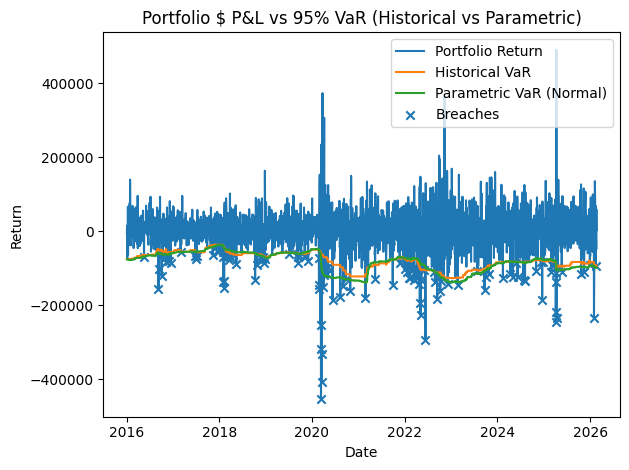

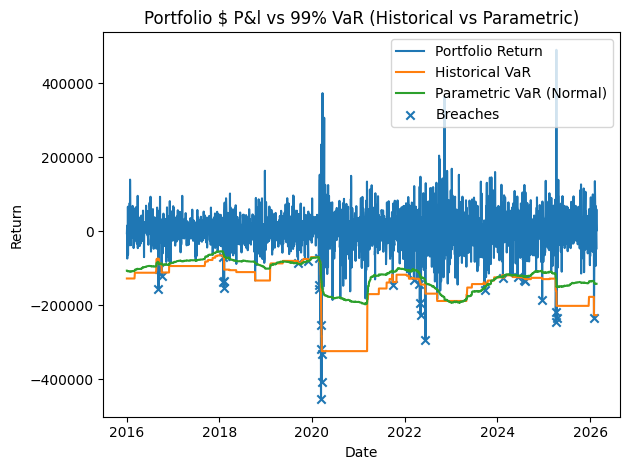

Parametric VAR (Normal) line = EWMA below


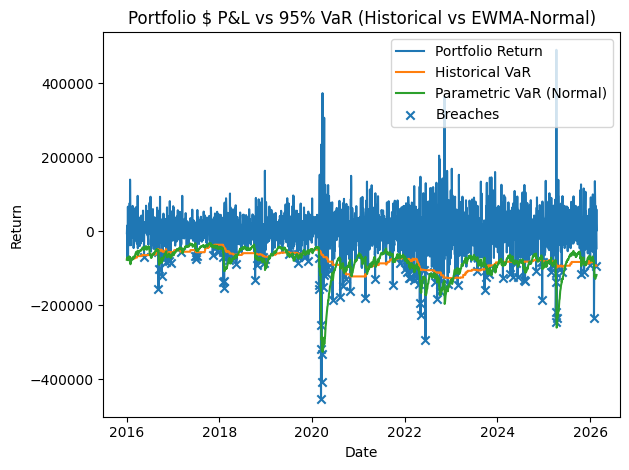

In [23]:
plot_var_overlay(
    returns=pnl,
    var_hist=var95_hist_dollars,
    var_param=var95_param_dollars,
    title="Portfolio $ P&L vs 95% VaR (Historical vs Parametric)",
    outpath="../outputs/figures/var_95_overlay_dollars.png",
)
plot_var_overlay(
    returns=pnl,
    var_hist=var99_hist_dollars,
    var_param=var99_param_dollars,
    title="Portfolio $ P&l vs 99% VaR (Historical vs Parametric)",
    outpath="../outputs/figures/var_99_overlay_dollars.png",
)
print("Parametric VAR (Normal) line = EWMA below")
plot_var_overlay(
    returns=pnl,
    var_hist=var95_hist_dollars,
    var_param=var95_ewma_dollars,
    title="Portfolio $ P&L vs 95% VaR (Historical vs EWMA-Normal)",
    outpath="../outputs/figures/var_95_overlay_ewma.png",
)

## Pre-Trade Impact (Simple)

In [24]:
port_new = Portfolio(weights={"SPY": 0.6, "TLT": 0.2, "GLD": 0.1, "UUP": 0.1})

pret_new = portfolio_returns(rets, port_new)
pnl_new = scale_to_dollars(pret_new, NOTIONAL)

var95_hist_new = historical_var(pret_new, window=WINDOW, alpha=0.05)
var95_param_new = parametric_var_normal(pret_new, window=WINDOW, alpha=0.05, use_mean=True)
var99_hist_new = historical_var(pret_new, window=WINDOW, alpha=0.01)
var99_param_new = parametric_var_normal(pret_new, window=WINDOW, alpha=0.01, use_mean=True)

var95_hist_new_dollars = scale_to_dollars(var95_hist_new, NOTIONAL)
var95_param_new_dollars = scale_to_dollars(var95_param_new, NOTIONAL)
var99_hist_new_dollars = scale_to_dollars(var99_hist_new, NOTIONAL)
var99_param_new_dollars = scale_to_dollars(var99_param_new, NOTIONAL)

comparison = pd.DataFrame({
    "VaR95_hist_old_$": var95_hist_dollars.dropna().round(2),
    "VaR95_hist_new_$": var95_hist_new_dollars.dropna().round(2),
    "VaR95_param_old_$": var95_param_dollars.dropna().round(2),
    "VaR95_param_new_$": var95_param_new_dollars.dropna().round(2),
    "VaR99_hist_old_$": var99_hist_dollars.dropna().round(2),
    "VaR99_hist_new_$": var99_hist_new_dollars.dropna().round(2),
    "VaR99_param_old_$": var99_param_dollars.dropna().round(2),
    "VaR99_param_new_$": var99_param_new_dollars.dropna().round(2),
}).dropna()

comparison.tail().round(2)


,VaR95_hist_old_$,VaR95_hist_new_$,VaR95_param_old_$,VaR95_param_new_$,VaR99_hist_old_$,VaR99_hist_new_$,VaR99_param_old_$,VaR99_param_new_$
Date,,,,,,,,
2026-02-12,-93041.73,-110003.29,-98761.82,-122918.65,-226877.21,-236788.19,-142420.31,-176065.18
2026-02-13,-93041.73,-110003.29,-98309.38,-122524.61,-226877.21,-236788.19,-141976.92,-175647.16
2026-02-17,-93041.73,-110003.29,-98593.76,-122633.47,-226877.21,-236788.19,-142130.15,-175615.47
2026-02-18,-93041.73,-110003.29,-98404.49,-122482.36,-226877.21,-236788.19,-141988.34,-175498.02
2026-02-19,-93041.73,-110003.29,-98437.62,-122522.65,-226877.21,-236788.19,-142021.42,-175537.71


## Summary of Pre-Trade Change

In [25]:
latest = comparison.iloc[-1]
delta_hist_95 = latest["VaR95_hist_new_$"] - latest["VaR95_hist_old_$"]
delta_param_95 = latest["VaR95_param_new_$"] - latest["VaR95_param_old_$"]
delta_hist_99 = latest["VaR99_hist_new_$"] - latest["VaR99_hist_old_$"]
delta_param_99 = latest["VaR99_param_new_$"] - latest["VaR99_param_old_$"]

print("95% VaR Pre-Trade Change")
print(f"VaR95_hist_old_$: {latest['VaR95_hist_old_$']:.2f}")
print(f"VaR95_hist_new_$: {latest['VaR95_hist_new_$']:.2f}")
print(f"VaR95_param_old_$: {latest['VaR95_param_old_$']:.2f}")
print(f"VaR95_param_new_$: {latest['VaR95_param_new_$']:.2f}")
print(f"delta_hist_$: {delta_hist_95:.2f}")
print(f"delta_param_$: {delta_param_95:.2f}\n")
print("99% VaR Pre-Trade Change")
print(f"VaR99_hist_old_$: {latest['VaR99_hist_old_$']:.2f}")
print(f"VaR99_hist_new_$: {latest['VaR99_hist_new_$']:.2f}")
print(f"VaR99_param_old_$: {latest['VaR99_param_old_$']:.2f}")
print(f"VaR99_param_new_$: {latest['VaR99_param_new_$']:.2f}")
print(f"delta_hist_$: {delta_hist_99:.2f}")
print(f"delta_param_$: {delta_param_99:.2f}")


95% VaR Pre-Trade Change
VaR95_hist_old_$: -93041.73
VaR95_hist_new_$: -110003.29
VaR95_param_old_$: -98437.62
VaR95_param_new_$: -122522.65
delta_hist_$: -16961.56
delta_param_$: -24085.03

99% VaR Pre-Trade Change
VaR99_hist_old_$: -226877.21
VaR99_hist_new_$: -236788.19
VaR99_param_old_$: -142021.42
VaR99_param_new_$: -175537.71
delta_hist_$: -9910.98
delta_param_$: -33516.29
